---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Generating regular lattices and visualizing shortest paths
### Creating data for testing and demonstrating routes

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is a walk-through for:**

1. Instantiating a simple network through a generated regular lattice
2. Generating shortest path geometric objects
3. Visualizing shortest paths

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext watermark
%watermark

Last updated: 2021-06-28T19:34:05.940066-04:00

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
import libpysal
from libpysal.cg import Point
import matplotlib
import matplotlib.pyplot as plt
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.2.0

libpysal  : 4.4.0
spaghetti : 1.6.2
matplotlib: 3.4.2
json      : 2.0.9



-----------------------------
### 1. Demonstration with a synthetic network
#### 1.1 Instantiate a network from a 4x4 regular lattice

In [4]:
lattice = spaghetti.regular_lattice((0,0,3,3), 2, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

#### 1.2. Extract network elements and visualize them

In [5]:
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

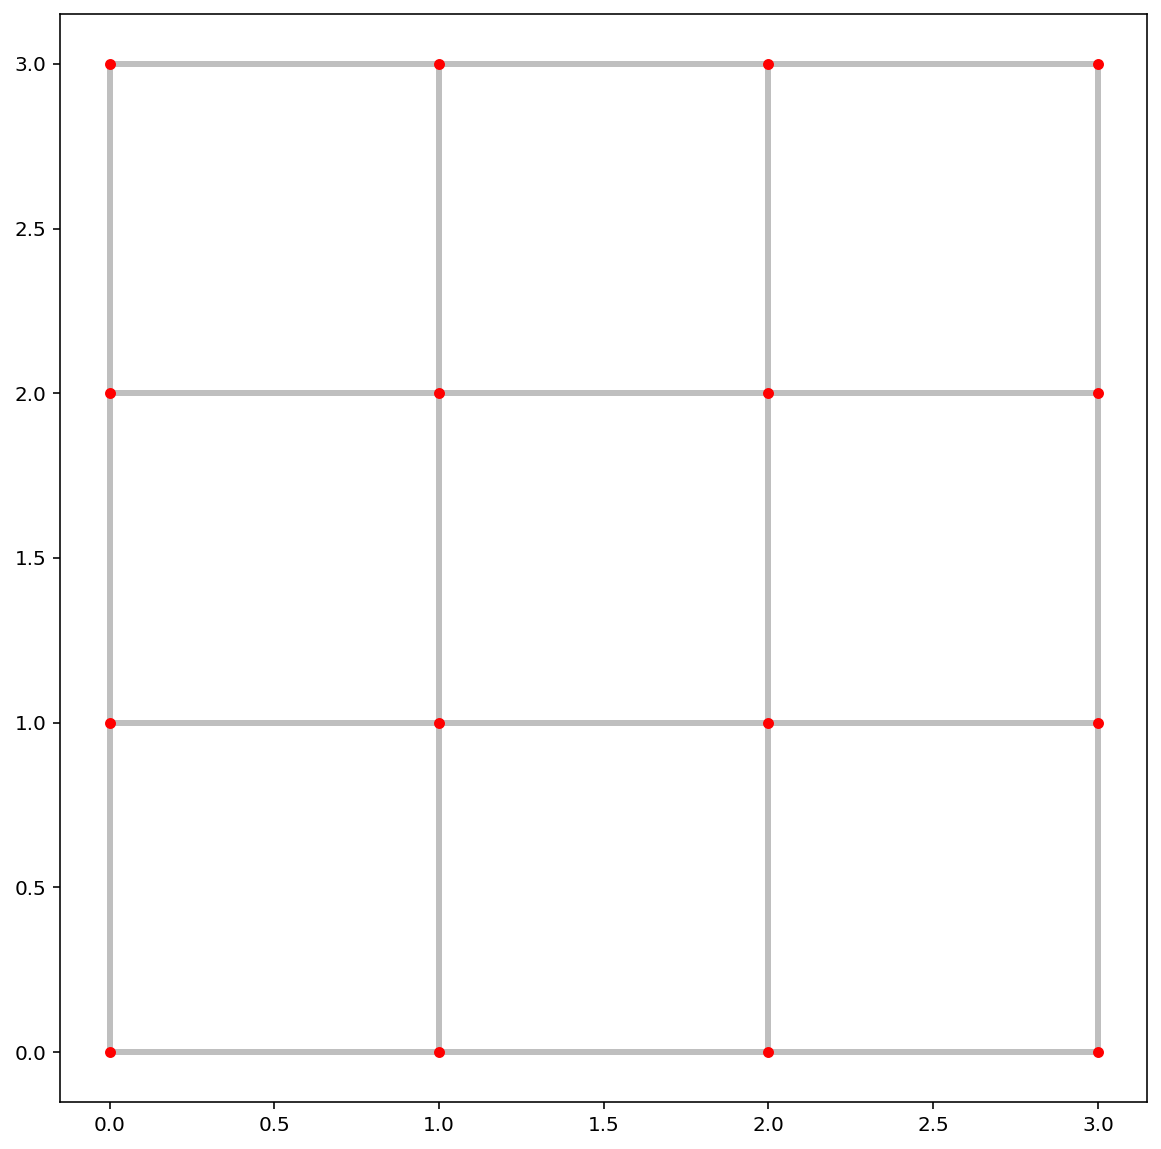

In [6]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=20, color="red", zorder=1);

#### 1.3. Instantiate several synthetic observations and snap them to the network

In [7]:
synth_obs = [Point([0.2, 1.3]), Point([0.2, 1.7]), Point([2.8, 1.5])]
ntw.snapobservations(synth_obs, "synth_obs")

#### 1.4. Extract point patterns and visualize plot
##### Note the labeling for network elements and observations

In [8]:
# true locations of synthetic observations
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="synth_obs")
# snapped locations of synthetic observations
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="synth_obs", snapped=True)

#### 1.4.1. Defined helper functions for labeling

In [9]:
def arc_labels(a, b, s):
    """Label each leg of the tour."""
    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]
    kws = {"size": s, "ha": "center", "va": "bottom"}
    a.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Helper for labeling vertices."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)
    
def obs_labels(o, b, s, c="g"):
    """Label each point pattern observation."""
    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "style": "oblique", "c":c}
    o.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

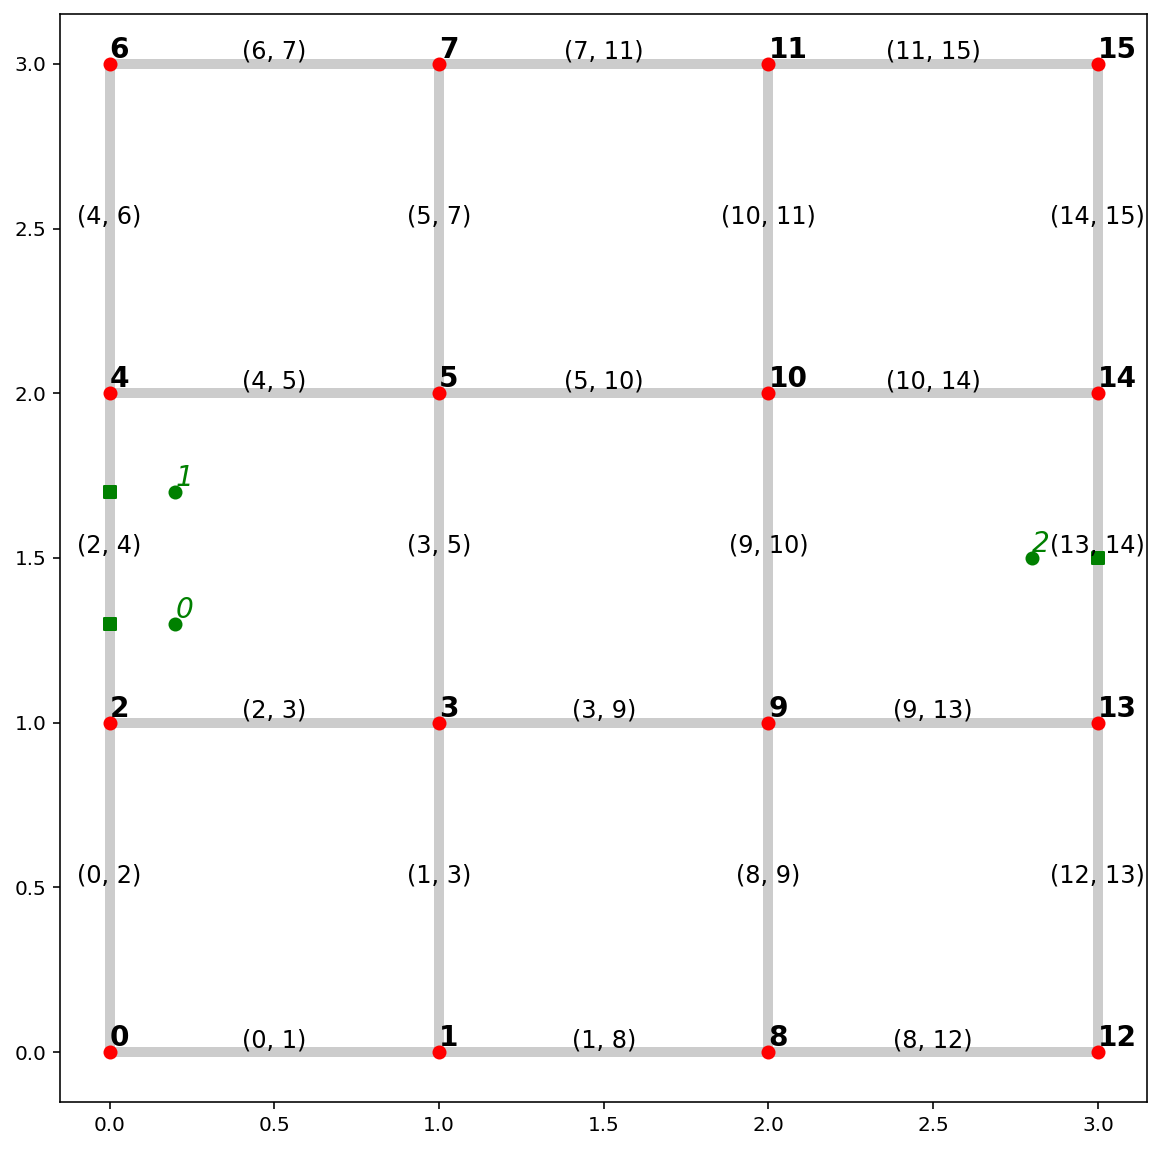

In [10]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
vertices.plot(ax=base, color="r", zorder=1)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arc_labels(arcs, base, 12)
# vertex labels
vert_labels(vertices, base, 14)
# synthetic observation labels
obs_labels(pp_obs, base, 14);

#### 1.5. Generate observation shortest path trees

In [11]:
d2d_dist, tree = ntw.allneighbordistances("synth_obs", gen_tree=True)
d2d_dist

array([[nan, 0.4, 3.8],
       [0.4, nan, 3.8],
       [3.8, 3.8, nan]])

##### Note that a tag of ``(-0.1, -0.1)`` labels the points as being snapped to the same network arc

In [12]:
tree

{(0, 1): (-0.1, -0.1), (0, 2): (2, 13), (1, 2): (4, 14)}

#### 1.6. Generate shortest paths as ``libpysal.cg.Chain`` objects

In [13]:
paths = ntw.shortest_paths(tree, "synth_obs")
paths

[[(0, 1), <libpysal.cg.shapes.Chain at 0x164ed0b50>],
 [(0, 2), <libpysal.cg.shapes.Chain at 0x164ed0eb0>],
 [(1, 2), <libpysal.cg.shapes.Chain at 0x164eff220>]]

#### 1.7. Extract the shortest paths within ``geopandas.GeoDataFrame`` and plot

In [14]:
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf

,geometry,O,D,id
0,"LINESTRING (0.00000 1.30000, 0.00000 1.70000)",0,1,"(0, 1)"
1,"LINESTRING (0.00000 1.30000, 0.00000 1.00000, ...",0,2,"(0, 2)"
2,"LINESTRING (0.00000 1.70000, 0.00000 2.00000, ...",1,2,"(1, 2)"


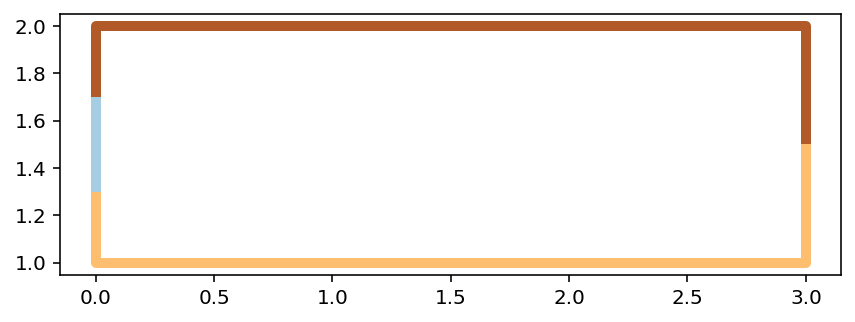

In [15]:
paths_gdf.plot(figsize=(7, 7), column=paths_gdf.index.name, cmap="Paired", linewidth=5);

#### 1.8. Plot the routes within the context of the network

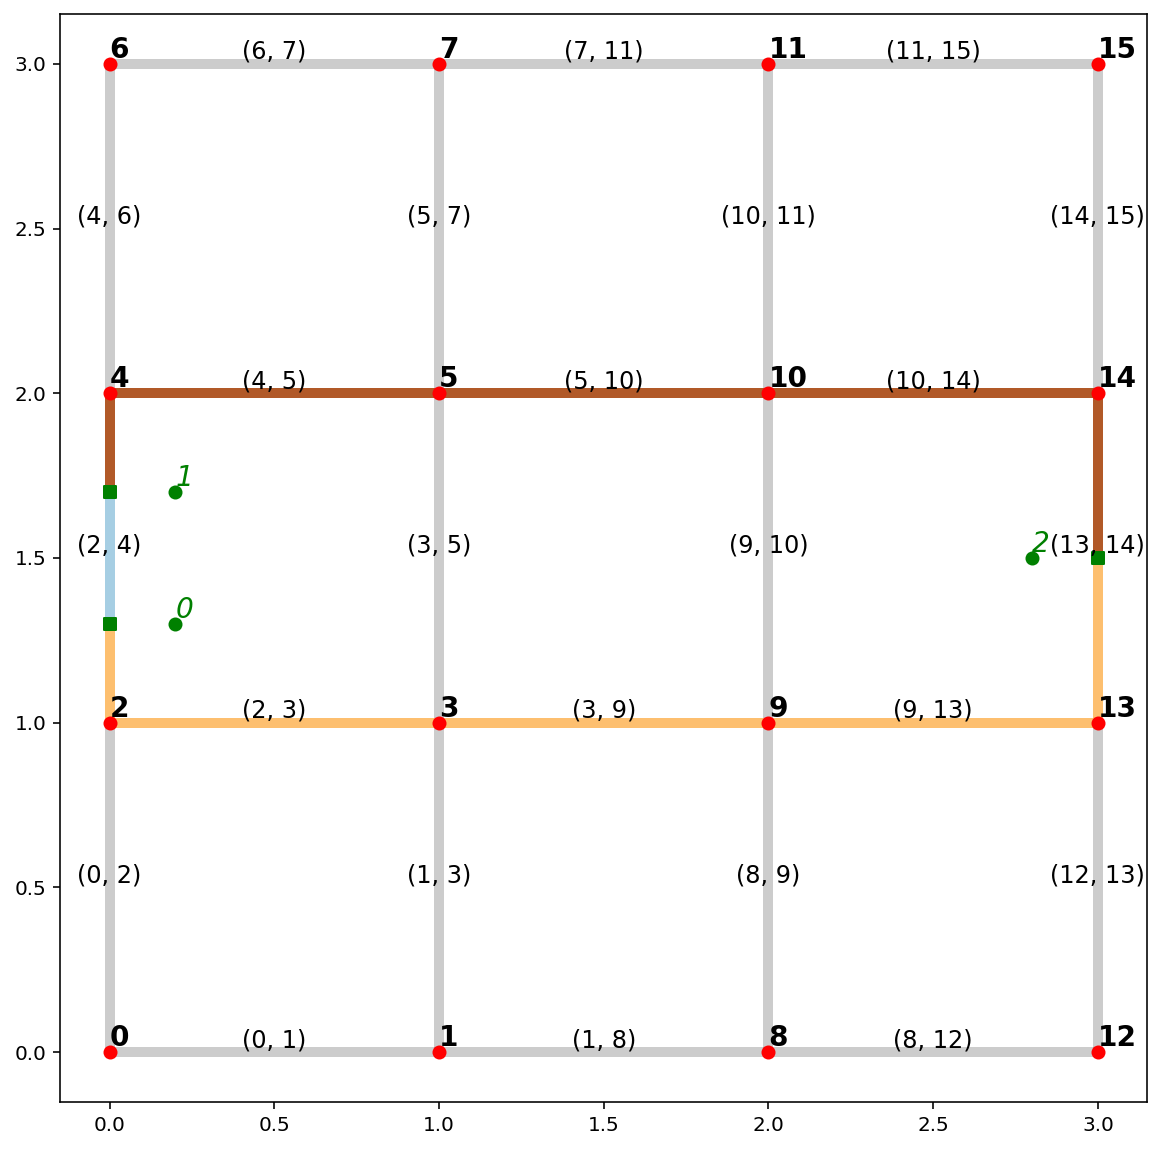

In [16]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=5, zorder=1)
vertices.plot(ax=base, color="r", zorder=2)
pp_obs.plot(ax=base, color="g", zorder=3)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arc_labels(arcs, base, 12)
# vertex labels
vert_labels(vertices, base, 14)
# synthetic observation labels
obs_labels(pp_obs, base, 14);

-----------------------------------
### 2. Demostration with emprical datasets
#### 2.1 Instantiate an emprical network, extract elements, and visualize

In [17]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

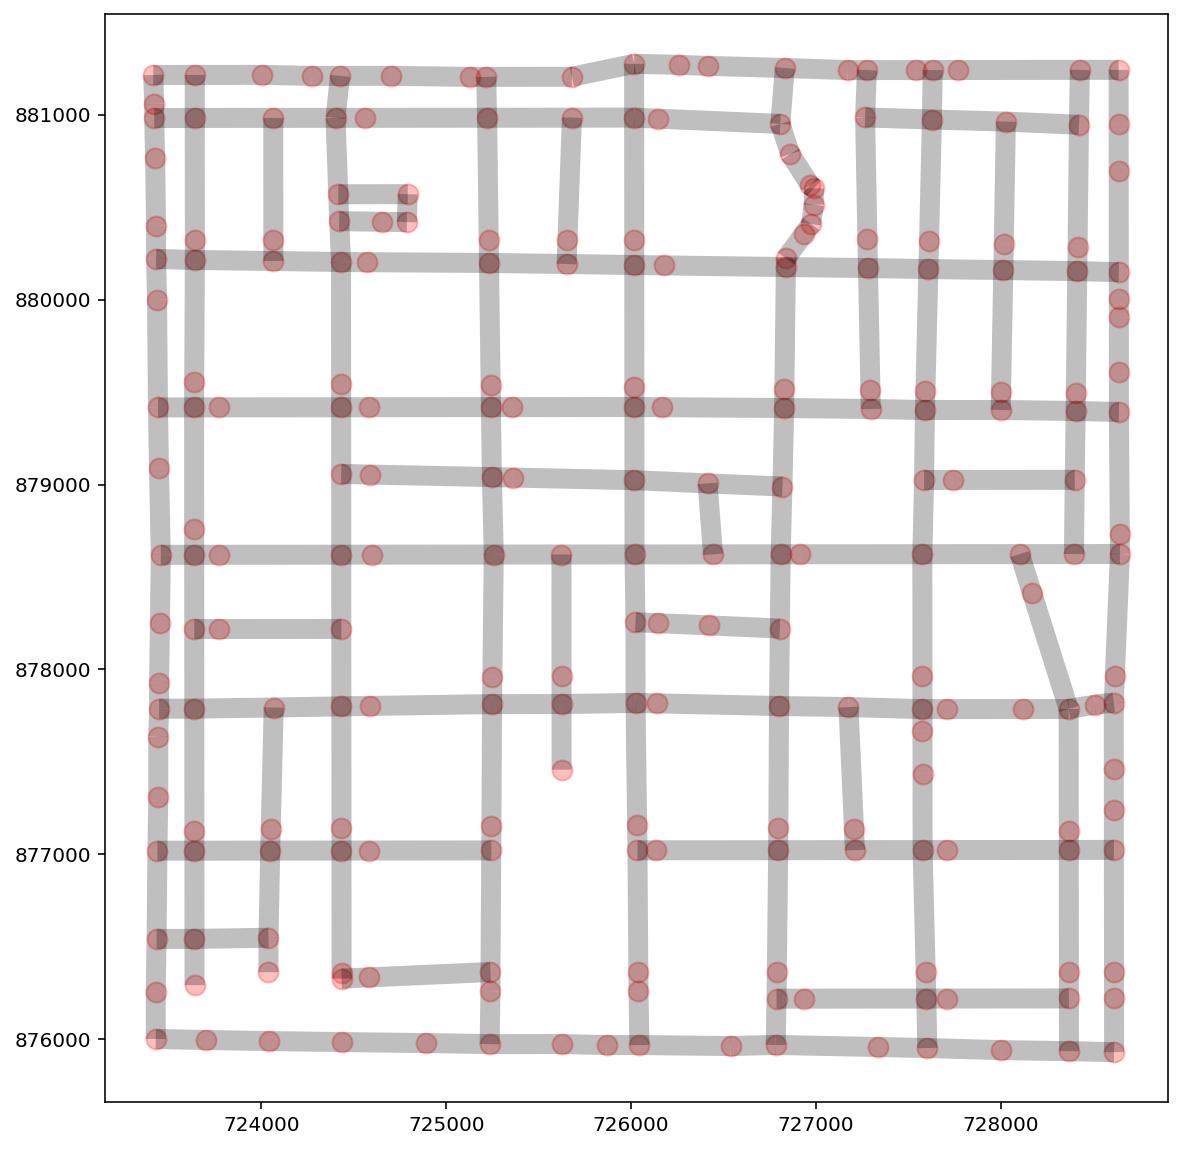

In [18]:
base = arcs.plot(linewidth=10, alpha=0.25, color="k", figsize=(10, 10))
vertices.plot(ax=base, markersize=100, alpha=0.25, color="red");

#### 2.2 Snap emprical observations and extract the point patterns as ``geopandas.GeoDataFrames``

In [19]:
ntw.snapobservations(libpysal.examples.get_path("schools.shp"), "schools")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="schools")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="schools", snapped=True)

#### 2.3 Plot empirical data

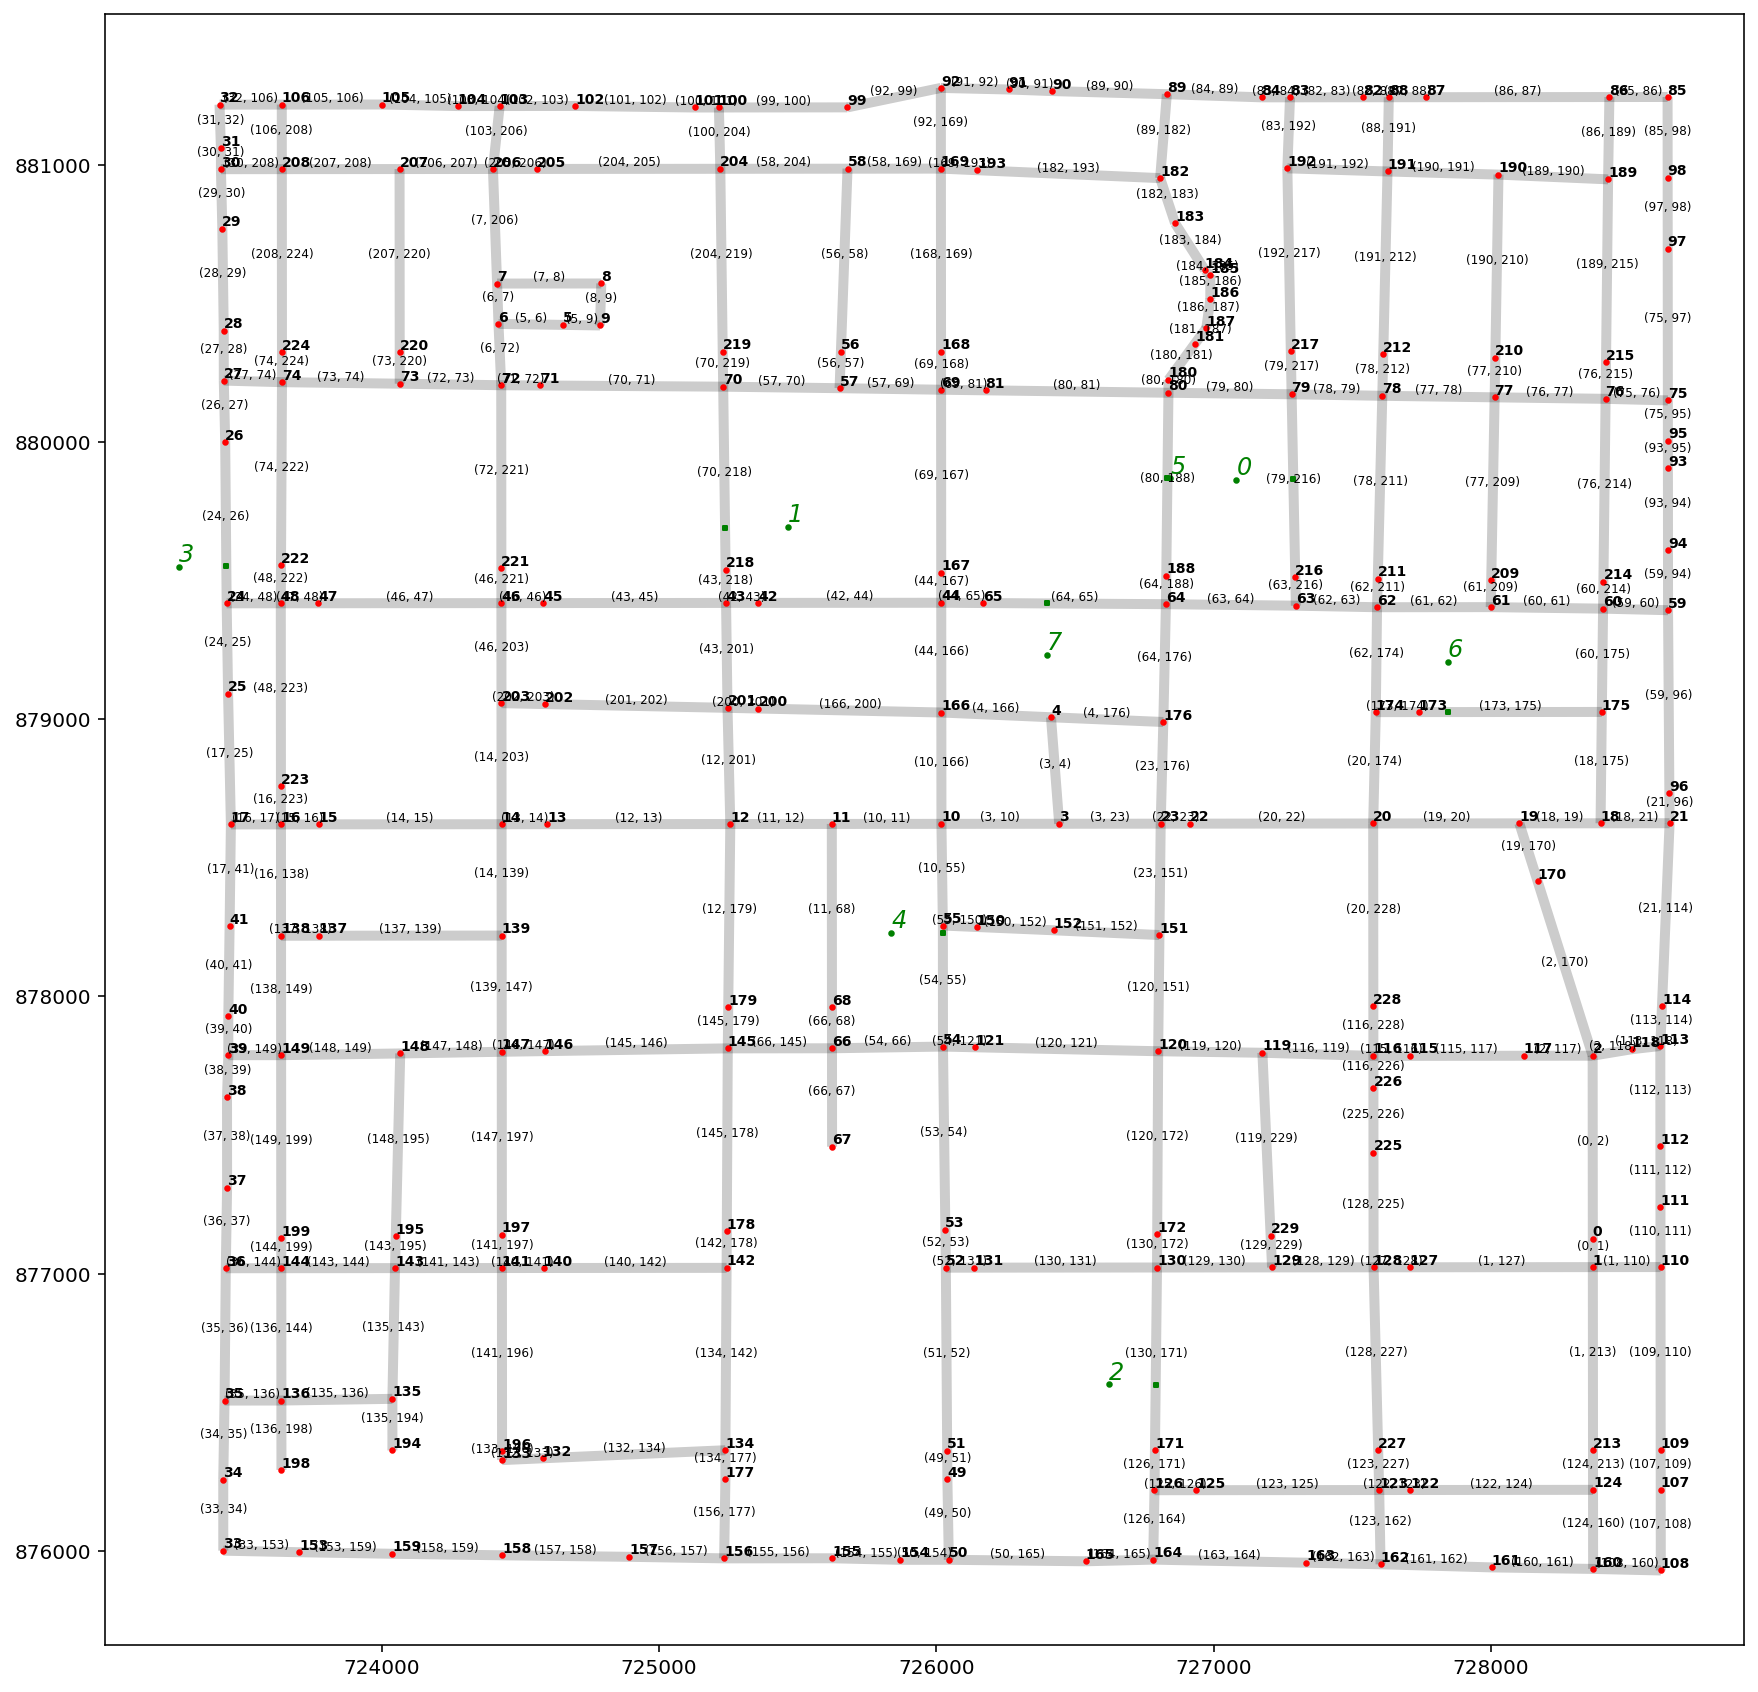

In [20]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(15, 15), zorder=0)
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=5, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=5, marker="s", color="g", zorder=2)
# arc labels
arc_labels(arcs, base, 6)
# vertex labels
vert_labels(vertices, base, 7)
# synthetic observation labels
obs_labels(pp_obs, base, 12);

#### 2.4 Generate shortest path routes and extract them

In [21]:
d2d_dist, tree = ntw.allneighbordistances("schools", gen_tree=True)
paths = ntw.shortest_paths(tree, "schools")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,geometry,O,D,id
0,"LINESTRING (727287.664 879867.386, 727294.797 ...",0,1,"(0, 1)"
1,"LINESTRING (727287.664 879867.386, 727294.797 ...",0,2,"(0, 2)"
2,"LINESTRING (727287.664 879867.386, 727294.797 ...",0,3,"(0, 3)"
3,"LINESTRING (727287.664 879867.386, 727294.797 ...",0,4,"(0, 4)"
4,"LINESTRING (727287.664 879867.386, 727281.557 ...",0,5,"(0, 5)"


#### 2.5 Plot the shortest path routes

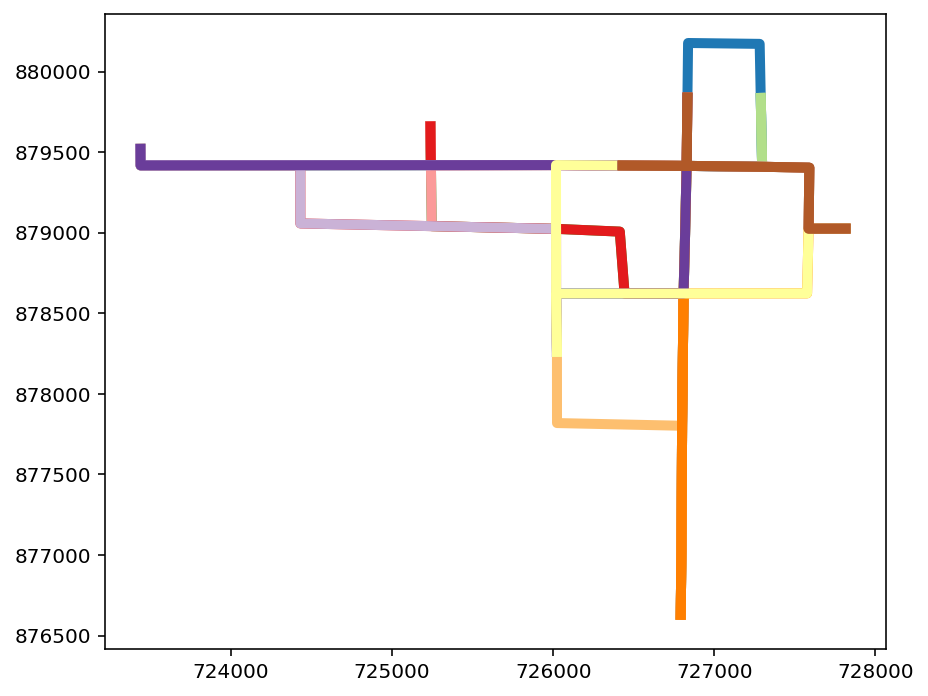

In [22]:
paths_gdf.plot(figsize=(7, 7), column="id", cmap="Paired", linewidth=5);

#### 2.6. Plot all shortest path routes within the context of the network

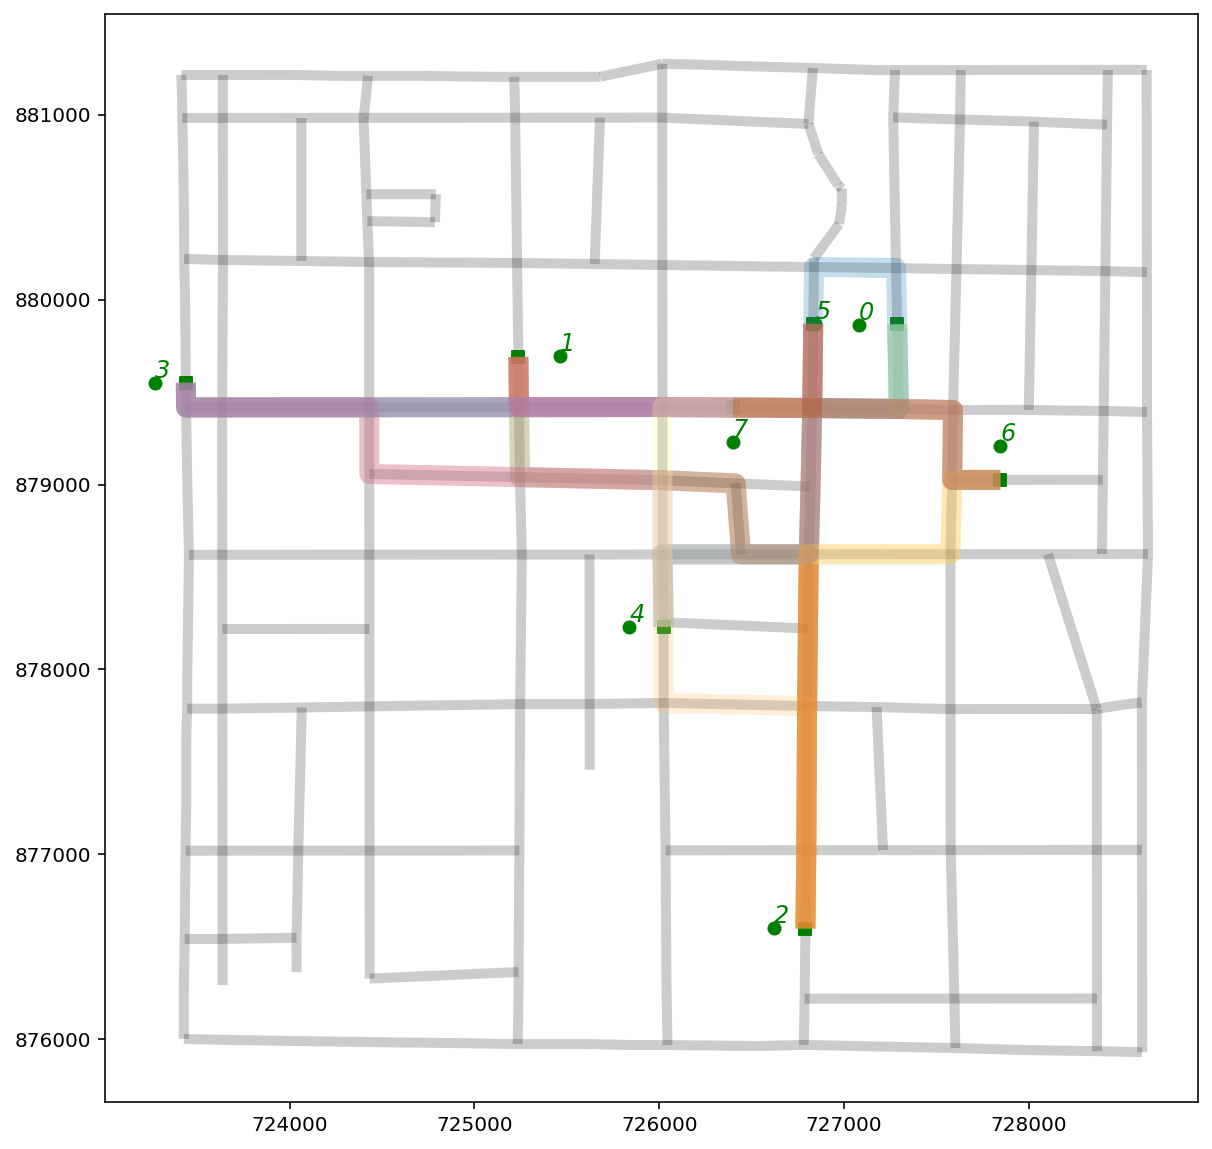

In [23]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=10, alpha=0.25)
# synthetic observation labels
obs_labels(pp_obs, base, 12);

#### 2.7. Plot the shortest path routes originating from observation ``0``

In [24]:
obs0 = 0
pp_ob0 = pp_obs[pp_obs["id"]==obs0]
pp_obX0 = pp_obs[pp_obs["id"]!=obs0]
orig_ob0 = paths_gdf[paths_gdf["O"]==obs0]

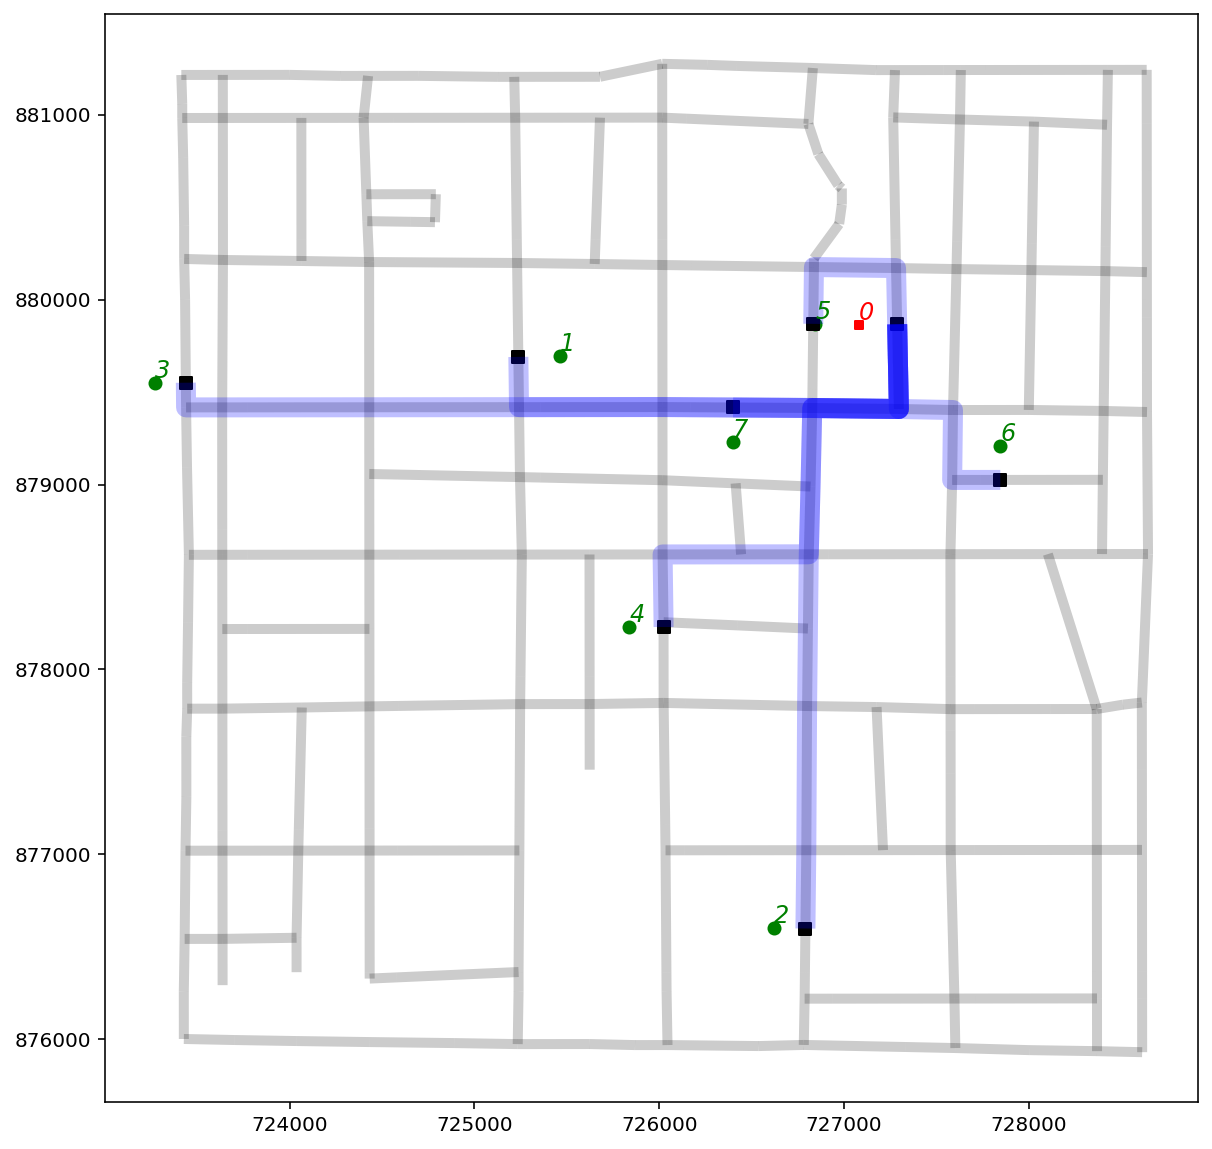

In [25]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obX0.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="k", marker="s", zorder=2)
pp_ob0.plot(ax=base, markersize=20, marker="s", color="r", zorder=2)
# routes originating from observation 0
orig_ob0.plot(ax=base, color="b", linewidth=10, alpha=0.25);
# synthetic observation labels
obs_labels(pp_obX0, base, 12, c="g");
# synthetic observation labels
obs_labels(pp_ob0, base, 12, c="r");

#### 2.8. Plot the shortest path routes arriving at observation ``4``
Since the point pattern is symmetric, origins equal destinations and the shortest paths IDs are sorted and pruned out. Therefore, we have to stipluate ***either*** ``O`` or ``D`` of ``4`` in this case.

In [26]:
obs4 = 4
pp_ob4 = pp_obs[pp_obs["id"]==obs4]
pp_obX4 = pp_obs[pp_obs["id"]!=obs4]
orig_ob4 = paths_gdf[(paths_gdf["O"]==obs4)| (paths_gdf["D"]==obs4)]

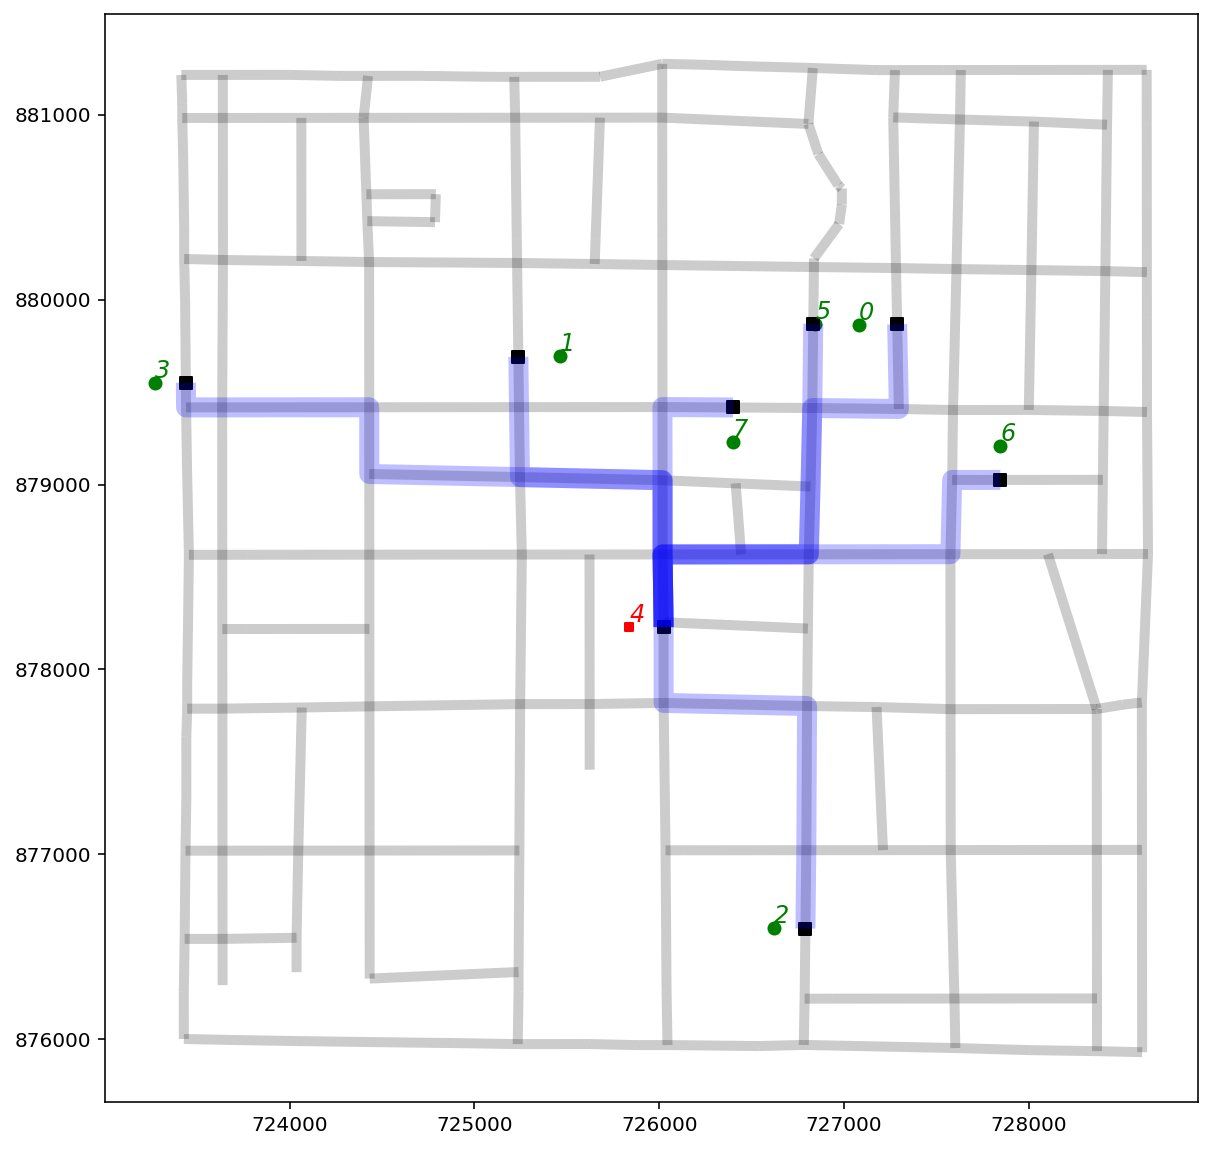

In [27]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obX4.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="k", marker="s", zorder=2)
pp_ob4.plot(ax=base, markersize=20, marker="s", color="r", zorder=2)
# routes originating from observation 4
orig_ob4.plot(ax=base, color="b", linewidth=10, alpha=0.25);
# synthetic observation labels
obs_labels(pp_obX4, base, 12, c="g");
# synthetic observation labels
obs_labels(pp_ob4, base, 12, c="r");

-----------------------